In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import numpy as np
import os

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

Loading BokehJS ...

In [11]:
import matplotlib as mpl
mpl.rcParams.update({
    'figure.figsize': (18, 13),
})

In [2]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

# Explore saved result

In [82]:
# filename = '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1329/201209/002/caiman_002_vertical.hdf5'
filename = '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1329/201209/002/caiman_002_1200_eval.hdf5'

cnm = cnmf.load_CNMF(filename, n_processes=n_processes, dview=dview)

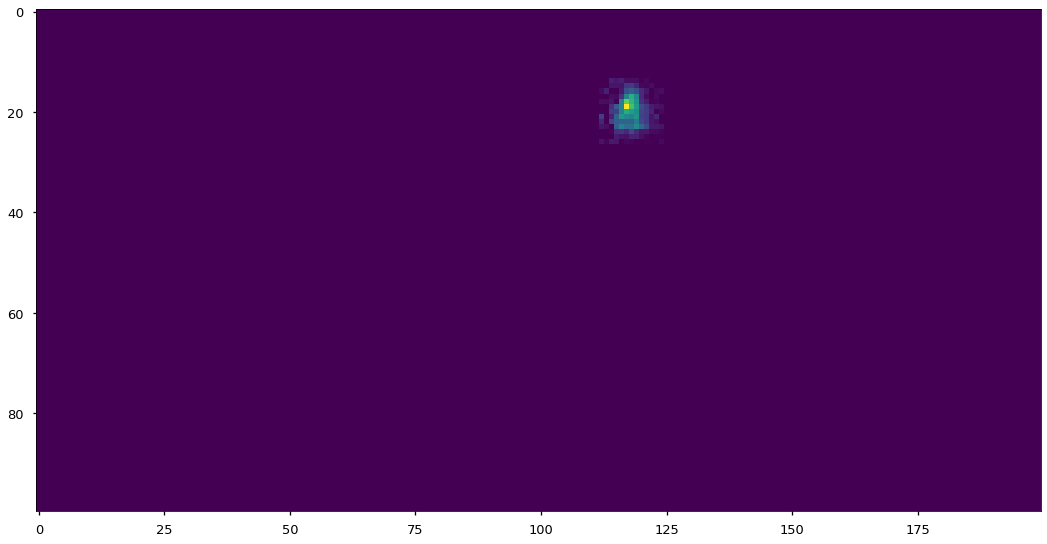

In [84]:
# check how to get all cell map: cell spatial info is in a sparse matrix. non-cell area = 0
from bokeh.plotting import figure, show

es = cnm.estimates
t = es.A[:,13].toarray().reshape([796,264], order='F')
plt.imshow(t[:100, :200])
# p.image(image=[t[:100, 50:150]], x=0, y=0, dw=10, dh=10, palette="Spectral11", level="image")
# p.grid.grid_line_width = 0.5
# show(p)

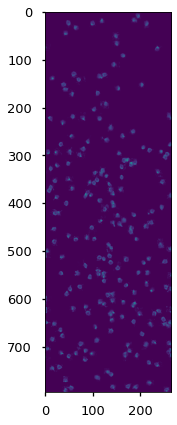

In [5]:
## add up every cell loc matrix to get overlaid all-cell map

cell_map = np.zeros([796,264])
for i in np.arange(es.A.shape[1]):
    t = es.A[:,i].toarray().reshape([796,264], order='F')
    cell_map = cell_map + t
    
fig = plt.figure(figsize=[16,7])
fig = plt.imshow(cell_map)

In [8]:
from custom_functions import loadmat
mat = 'Z:/All_Staff/home/lan/Analysis/2P/201209_i1329/201209_i1329_runs-002/201209_i1329_runs-002_mask_cell_addfake.mat'
t = loadmat(mat)
t.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data_dfof', 'mask_cell', 'mask_np'])

In [9]:
t['mask_cell'].shape

(264, 796)

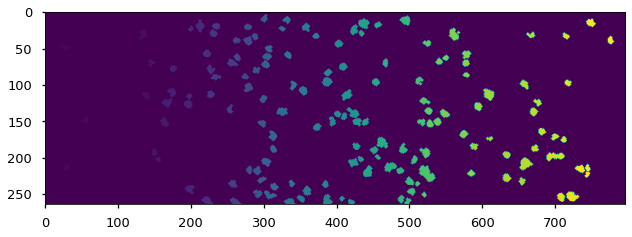

In [10]:
plt.imshow(t['mask_cell'])

In [12]:
np.unique(t['mask_cell'])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146], dtype=uint8)

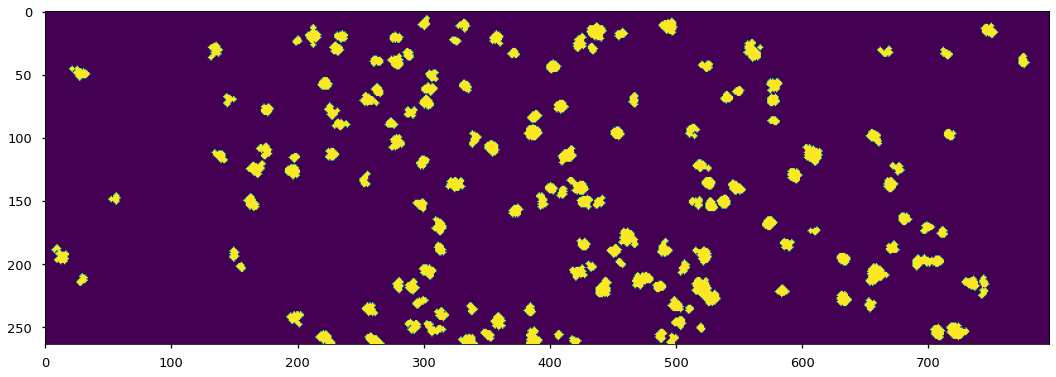

In [13]:
seg_ref = t['mask_cell'].copy()
sz = seg_ref.shape

seg_ref = seg_ref.flatten()
seg_ref[seg_ref>1] = 1
seg_ref = seg_ref.reshape(sz)

plt.imshow(seg_ref)

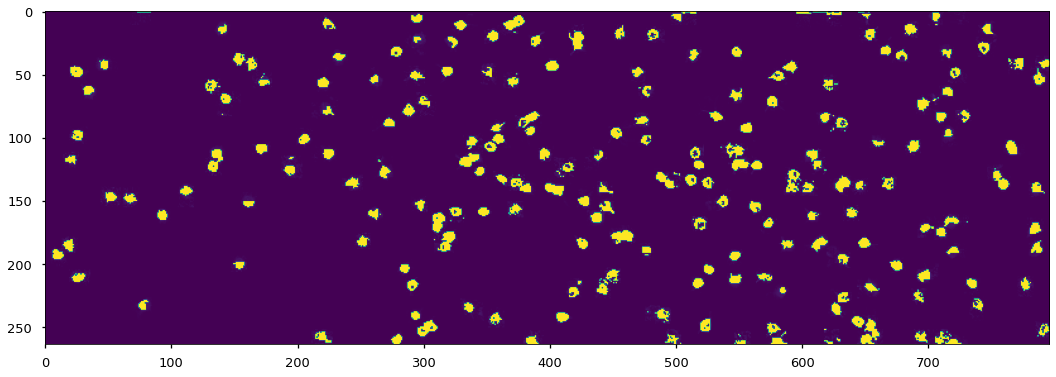

In [14]:
seg_caiman = cell_map.T
sz = seg_caiman.shape

seg_caiman = seg_caiman.flatten()
seg_caiman[seg_caiman>0.07] = 1
seg_caiman = seg_caiman.reshape(sz)

plt.imshow(seg_caiman)

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Trying to register the cmap 'rainbow_alpha' which already exists.
  app.launch_new_instance()


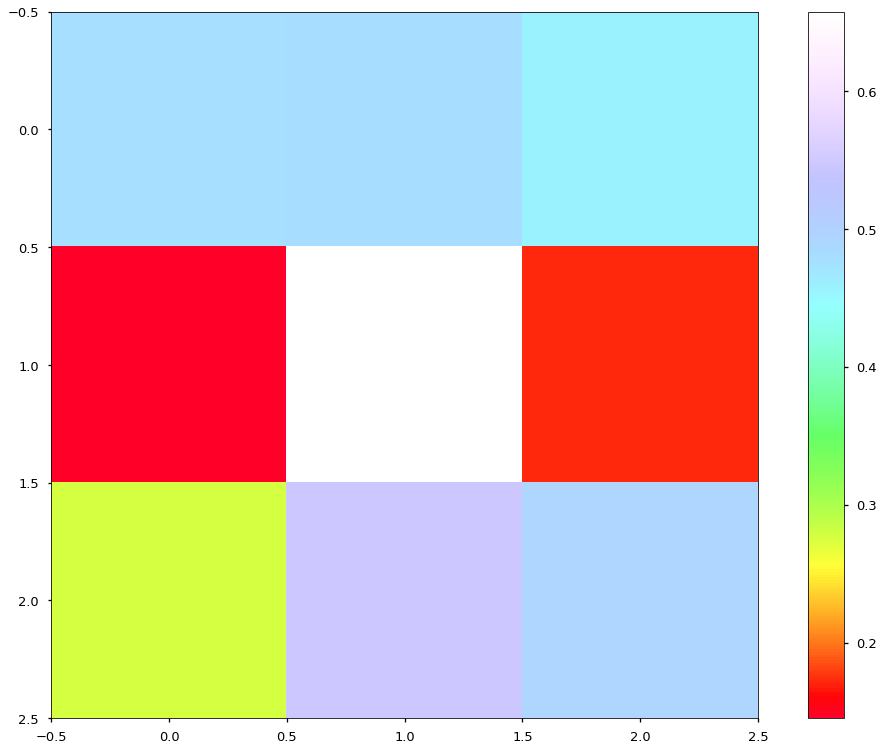

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(1.0,0.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

# show some example data
f,ax = plt.subplots()
h = ax.imshow(np.random.rand(3,3),cmap='rainbow_alpha')
plt.colorbar(mappable=h)

# Compare caiman vs manual seg

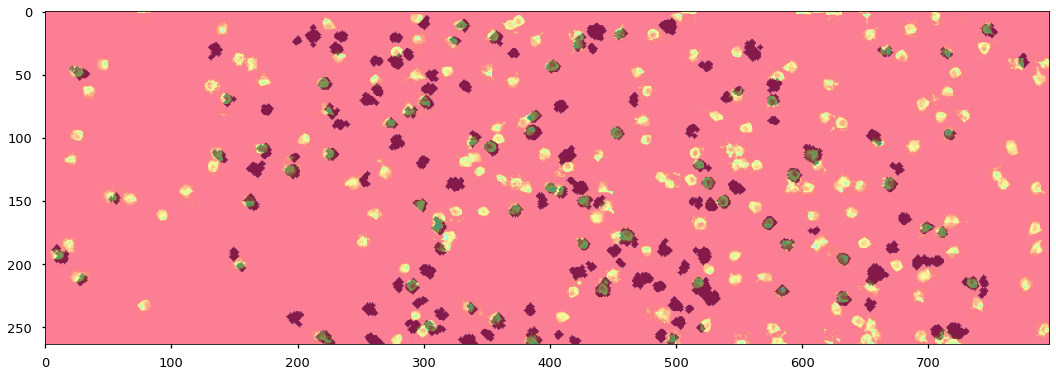

In [40]:
seg_caiman = cell_map.T
im1 = plt.imshow(seg_caiman, cmap='rainbow_alpha', alpha=0.99)
im2 = plt.imshow(seg_ref, cmap='Blues', alpha=0.5)
plt.show()

# Component eval

In [45]:
dir(cnm.estimates)

['A',
 'A_thr',
 'Ab',
 'Ab_dense',
 'AtA',
 'AtY_buf',
 'C',
 'CC',
 'CY',
 'C_on',
 'Cf',
 'F_dff',
 'OASISinstances',
 'R',
 'S',
 'SNR_comp',
 'W',
 'YrA',
 'Yr_buf',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'b',
 'b0',
 'bl',
 'c1',
 'center',
 'cnn_preds',
 'compute_background',
 'compute_residuals',
 'coordinates',
 'deconvolve',
 'detrend_df_f',
 'dims',
 'discarded_components',
 'ecc',
 'evaluate_components',
 'evaluate_components_CNN',
 'f',
 'filter_components',
 'g',
 'groups',
 'hv_view_components',
 'idx_components',
 'idx_components_bad',
 'ind_new',
 'lam',
 'make_color_movie',
 'manual_merge',
 'masks_2_neurofinder',
 'merge_components',
 'merge

In [50]:
%pdef cm.load_memmap

 cm.load_memmap(filename: str, mode: str = 'r') -> Tuple[Any, Tuple, int]
 

In [53]:
mmap_name = '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1329/201209/002/002_vertical_els__d1_796_d2_264_d3_1_order_F_frames_1200_.mmap'
Yr, dims, T = cm.load_memmap(mmap_name)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0

# cnm.estimates.plot_contours_nb(img=Cn, idx=cnm.estimates.idx_components)
# cnm.estimates.plot_contours_nb(img=Cn)

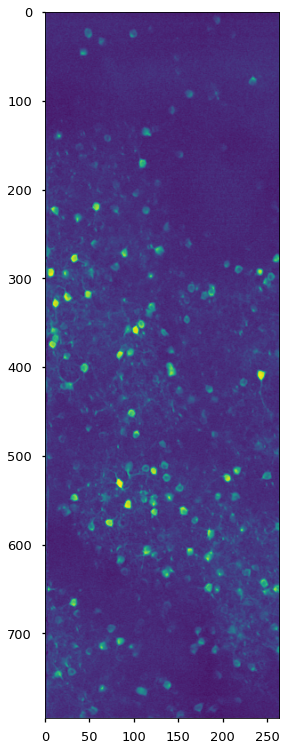

In [58]:
plt.imshow(Cn)

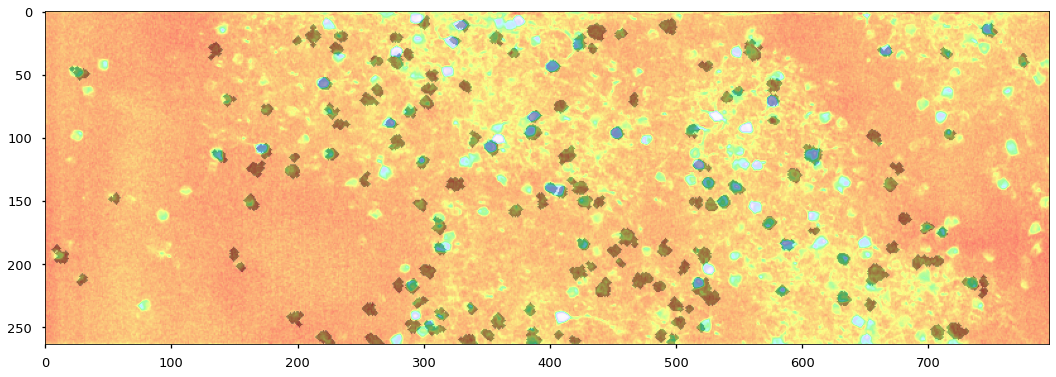

In [81]:
seg_caiman = Cn.T
im1 = plt.imshow(seg_caiman, cmap='rainbow_alpha', alpha=1)
im2 = plt.imshow(seg_ref, cmap='Blues', alpha=0.4)
plt.show()

In [59]:
cnm.estimates.cnn_preds.shape

(220,)

In [60]:
cnm.estimates.cnn_preds[0]

0.31768435

In [62]:
%pfile cnm.estimates.plot_contours_nb

In [85]:
print(cnm.estimates.idx_components)

[  13   24   43  130  195  200  228  229  242  250  325  368  371  402
  406  421  430  431  445  447  458  466  469  470  483  487  491  494
  495  496  510  518  521  534  544  553  567  570  572  586  589  598
  610  626  627  644  648  650  655  657  661  679  680  684  701  708
  710  713  722  728  740  742  747  751  756  757  780  782  783  800
  812  813  824  843  849  851  868  905  906  929  942  949  962  963
  964  965  966  969  970  971  972  973  975  976  977  979  980  981
  982  983  984  985  987  988  989  992  996  997  999 1000 1001 1003
 1004 1007 1008 1010 1011 1012 1015 1016 1017 1018 1019 1021 1022 1023
 1024 1025 1027 1028 1029 1030 1031 1032 1033 1036 1037 1038 1039 1041
 1042 1044 1046 1047 1048 1049 1051 1052 1054 1055 1057 1058 1059 1061
 1062 1063 1064 1065 1066 1068 1069 1070 1071 1072 1073 1074 1076 1079
 1080 1082 1083 1085 1086 1087 1088 1090 1092 1094 1095 1097 1100 1101
 1103 1105 1107 1116 1117 1119 1120 1125 1127 1139 1140 1142 1148 1153
 1158]

In [100]:
rval, snr, cnn = check_eval_results_LL(cnm, [13], True)
rval, snr, cnn
# check_eval_results(cnm, [13])

Checking component 14...

Component 14 got accepted, all lower threshold were passed!

	Upper thresholds:

	SNR of 1.98 does not exceed threshold of 2.0

	R-value of 0.88 exceeds threshold of 0.85

	CNN-value of 0.32 does not exceed threshold of 0.99





(1.9771576370157184, 0.8756582329782446, 0.3176839)

In [185]:
# import pylab as pl
# from caiman.base.rois import com
# def plot_contours_LL(A, Cn, thr=None, thr_method='max', maxthr=0.2, nrgthr=0.9, alpha_contour=0.5, display_numbers=True, 
#                      max_number=None, cmap=None, swap_dim=False, colors='w', vmin=None, vmax=None, coordinates=None,
#                      zoom_in = False, contour_args={}, number_args={}, **kwargs):
    
#     """Plots contour of spatial components against a background image and returns their coordinates
       
#        LL edit: zoom in on single cell and only plot its proximity. set cell contour alpha transparency
       
#      Args:
#          A:   np.ndarray or sparse matrix
#                    Matrix of Spatial components (d x K)
    
#          Cn:  np.ndarray (2D)
#                    Background image (e.g. mean, correlation)
    
#          thr_method: [optional] string
#                   Method of thresholding:
#                       'max' sets to zero pixels that have value less than a fraction of the max value
#                       'nrg' keeps the pixels that contribute up to a specified fraction of the energy
    
#          maxthr: [optional] scalar
#                     Threshold of max value
    
#          nrgthr: [optional] scalar
#                     Threshold of energy
    
#          thr: scalar between 0 and 1
#                    Energy threshold for computing contours (default 0.9)
#                    Kept for backwards compatibility. If not None then thr_method = 'nrg', and nrgthr = thr
    
#          display_number:     Boolean
#                    Display number of ROIs if checked (default True)
    
#          max_number:    int
#                    Display the number for only the first max_number components (default None, display all numbers)
    
#          cmap:     string
#                    User specifies the colormap (default None, default colormap)
                   
#          zoom_in:  boolean
#                    whether to zoom in on single cell position and only plot its proximity
                   
#      Returns:
#           coordinates: list of coordinates with center of mass, contour plot coordinates and bounding box for each component
#     """

#     if swap_dim:
#         Cn = Cn.T
#         print('Swapping dim')
        
#     if coordinates is None:
#         coordinates = get_contours(A, np.shape(Cn), thr, thr_method, swap_dim)    
    
#     if zoom_in:
#         ypos = np.floor(coordinates[0]['CoM']).astype(int)[0] # y position of caiman segmented cell's center of mass
#         proximity_range = 20 # plot how many pixels around CoM
#         Cn = Cn[max(ypos-proximity_range, 0):min(ypos+proximity_range, Cn.shape[0]), :] # do not exceed Cn nrow

#     if thr is None:
#         try:
#             thr = {'nrg': nrgthr, 'max': maxthr}[thr_method]
#         except KeyError:
#             thr = maxthr
#     else:
#         thr_method = 'nrg'


#     for key in ['c', 'colors', 'line_color']:
#         if key in kwargs.keys():
#             color = kwargs[key]
#             kwargs.pop(key)

#     ax = pl.gca()
#     if vmax is None and vmin is None:
#         pl.imshow(Cn, interpolation=None, cmap=cmap,
#                   vmin=np.percentile(Cn[~np.isnan(Cn)], 1),
#                   vmax=np.percentile(Cn[~np.isnan(Cn)], 99))
#     else:
#         pl.imshow(Cn, interpolation=None, cmap=cmap, vmin=vmin, vmax=vmax)

    
#     for c in coordinates:
#         v = c['coordinates']
#         if zoom_in:
# #             v = c[0]['coordinates']
#             v[:,1] = v[:,1] - max(0, ypos - proximity_range) # convert cell coordinates into zoomed in version
#         c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
#                      np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
#         pl.plot(*v.T, c=colors, **contour_args, alpha=alpha_contour)

#     if display_numbers:
#         d1, d2 = np.shape(Cn)
#         d, nr = np.shape(A)
#         cm = com(A, d1, d2)
#         if max_number is None:
#             max_number = A.shape[1]
#         for i in range(np.minimum(nr, max_number)):
#             if swap_dim:
#                 ax.text(cm[i, 0], cm[i, 1], str(i + 1), color=colors, **number_args)
#             else:
#                 ax.text(cm[i, 1], cm[i, 0], str(i + 1), color=colors, **number_args)
#     return coordinates

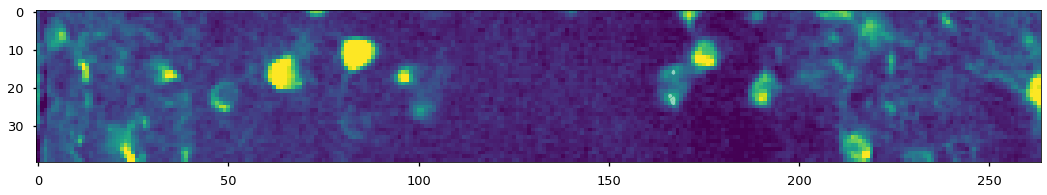

In [186]:
# crd = plot_contours_LL(cnm.estimates.A[:,1120], Cn, thr=0.9, display_numbers=False, zoom_in=True);

In [ ]:
from caiman.utils.visualization import plot_contours, get_contours
from post_analysis import check_eval_results_LL

for cell_id in cnm.estimates.idx_components:
    crd = plot_contours(cnm.estimates.A[:, cell_id], Cn, thr=0.9, display_numbers=False);
    snr, rval, cnn = check_eval_results_LL(cnm, [cell_id], print_score=False)
    
    plt.clf()
#     plt.figure()

    crd_converted = crd[0]['coordinates'].copy()
    crd_converted[:,1] = crd_converted[:,1] - (ypos-proximity_range)
    pl.plot(*crd_converted.T, color='white', alpha=1)

    ypos = np.floor(crd[0]['CoM']).astype(int)[0] # y position of caiman segmented cell's center of mass
    proximity_range = 50 # plot how many pixels around CoM
    Cn_chunk = Cn[max(ypos-proximity_range, 0):min(ypos+proximity_range, Cn.shape[0]), :] # do not exceed Cn nrow
    plt.imshow(Cn_chunk)

    snr_min = cnm.params.quality['SNR_lowest']
    snr_max = cnm.params.quality['min_SNR']
    r_min = cnm.params.quality['rval_lowest']
    r_max = cnm.params.quality['rval_thr']
    cnn_min = cnm.params.quality['cnn_lowest']
    cnn_max = cnm.params.quality['min_cnn_thr']

    color_snr = 'black'
    if snr < snr_min: color_snr = 'red';
    elif snr >= snr_max: color_snr = 'green';
    color_rval = 'black'
    if rval < r_min: color_rval = 'red';
    elif rval >= r_max: color_rval = 'green';
    color_cnn = 'black'
    if cnn < cnn_min: color_cnn = 'red';
    elif cnn >= cnn_max: color_cnn = 'green';

    txt_snr = 'snr = ' + ('%.2f' % snr) + " @ threshold (" + ('%.2f' % snr_min) + ", " + ('%.2f' % snr_max) + ")"
    txt_rval = 'rval = ' + ('%.2f' % rval) + " @ threshold (" + ('%.2f' % r_min) + ", " + ('%.2f' % r_max) + ")"
    txt_cnn = 'cnn = ' + ('%.2f' % cnn) + " @ threshold (" + ('%.2f' % cnn_min) + ", " + ('%.2f' % cnn_max) + ")"

    txt_ypos = 0.2
    plt.text(0.4, txt_ypos, txt_snr, fontsize=14, color=color_snr, transform=plt.gcf().transFigure)
    plt.text(0.4, txt_ypos-0.02, txt_rval, fontsize=14, color=color_rval, transform=plt.gcf().transFigure)
    plt.text(0.4, txt_ypos-0.04, txt_cnn, fontsize=14, color=color_cnn, transform=plt.gcf().transFigure);

    filename = 'eval_cell_' + str(cell_id) # cell id start from 0
    plt.savefig(filename +'.png', bbox_inches='tight')

# Corr activity vs stim

In [42]:
cnm.estimates.F_dff.shape

(220, 1200)

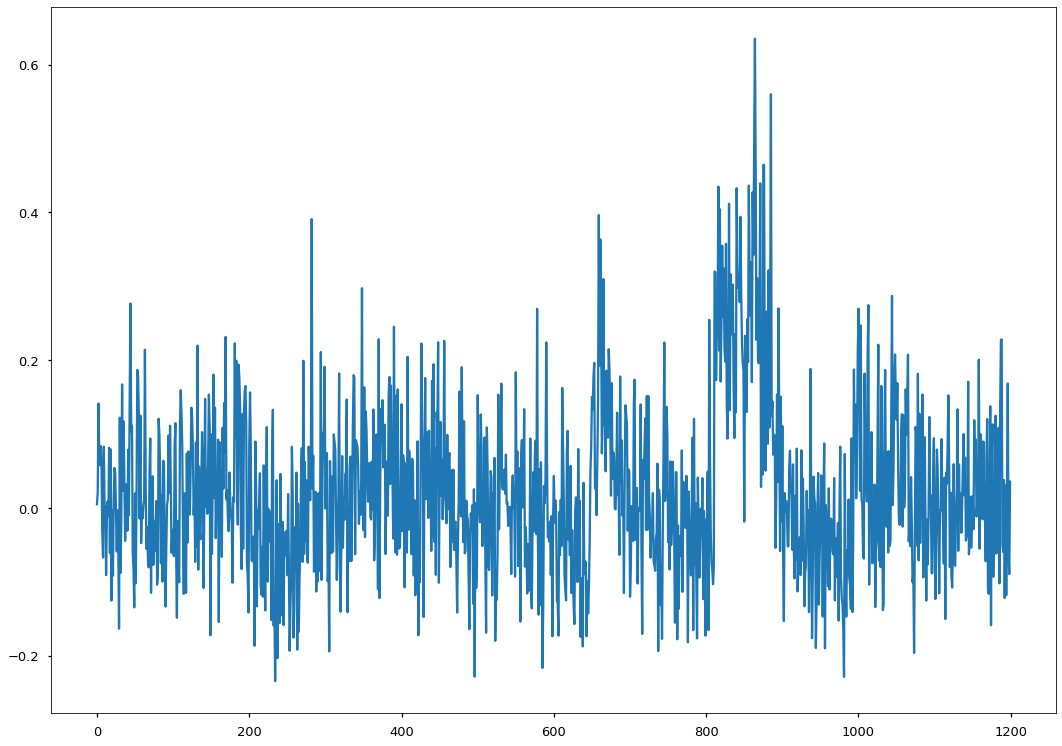

In [44]:
df_all = cnm.estimates.F_dff
df_0 = df_all[0,:]
plt.plot(df_0)